In [485]:
import sys
import os

# For working with data
import pandas as pd
import numpy as np
np.random.seed(123)

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For machine learning modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import set_config

In [486]:
print(os.getcwd())

/Users/joshbolton/ml_final_project/notebooks


In [487]:
customer_churn_raw = pd.read_csv('/Users/joshbolton/ml_final_project/data/raw/train.csv')
print(customer_churn_raw['Last Interaction'].head())
customer_churn_raw.info()

0    30.0
1    30.0
2    21.0
3    18.0
4     NaN
Name: Last Interaction, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303124 entries, 0 to 303123
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         303124 non-null  int64  
 1   Age                303124 non-null  int64  
 2   Gender             303124 non-null  object 
 3   Tenure             241103 non-null  float64
 4   Usage Frequency    303124 non-null  int64  
 5   Support Calls      240704 non-null  object 
 6   Payment Delay      214800 non-null  float64
 7   Subscription Type  303124 non-null  object 
 8   Contract Length    303124 non-null  object 
 9   Total Spend        303124 non-null  float64
 10  Last Interaction   240574 non-null  float64
 11  Customer Status    303124 non-null  object 
 12  Last Due Date      303124 non-null  object 
 13  Last Payment Date  303124 non-null  object 
 14  Churn      

In [488]:
print(customer_churn_raw.isnull().sum())
print(customer_churn_raw['Subscription Type'].value_counts())
print(customer_churn_raw['Contract Length'].value_counts())

CustomerID               0
Age                      0
Gender                   0
Tenure               62021
Usage Frequency          0
Support Calls        62420
Payment Delay        88324
Subscription Type        0
Contract Length          0
Total Spend              0
Last Interaction     62550
Customer Status          0
Last Due Date            0
Last Payment Date        0
Churn                    0
dtype: int64
Subscription Type
Premium     102969
Standard    102916
Basic        97239
Name: count, dtype: int64
Contract Length
Annual       130751
Quarterly    130402
Monthly       41971
Name: count, dtype: int64


## Cleaning Data

## Adding dummy variables
### Filling null values with column median values
### Giving non-numeric data some numeric values
### Changing dates of month-day to only month

In [489]:
customer_churn_cleaned = customer_churn_raw.copy()

#fill null values
customer_churn_cleaned['Tenure'] = customer_churn_cleaned['Tenure'].fillna(customer_churn_cleaned['Tenure'].median())
customer_churn_cleaned['Payment Delay'] = customer_churn_cleaned['Payment Delay'].fillna(customer_churn_cleaned['Payment Delay'].median())
customer_churn_cleaned['Last Interaction'] = customer_churn_cleaned['Last Interaction'].fillna(customer_churn_cleaned['Last Interaction'].median())

customer_churn_cleaned['Support Calls'] = customer_churn_cleaned['Support Calls'].replace({'None' : 0,'none' : 0})
customer_churn_cleaned['Support Calls'] = pd.to_numeric(customer_churn_cleaned['Support Calls']).fillna(0).astype(int)

#Give replacing non-numeric data with numeric replacements

customer_churn_cleaned['Gender'] = customer_churn_cleaned['Gender'].replace({'Male' : 0, 'Female' : 1})
customer_churn_cleaned['Customer Status'] = customer_churn_cleaned['Customer Status'].replace({'inactive' : 0, 'active' : 1})
customer_churn_cleaned['Subscription Type'] = customer_churn_cleaned['Subscription Type'].replace({'Basic' : 0, 'Standard' : 1, 'Premium' : 2})
customer_churn_cleaned['Contract Length'] = customer_churn_cleaned['Contract Length'].replace({'Annual' : 1, 'Quarterly' : 4, 'Monthly' : 12})

#changing date of month-day to only month

customer_churn_cleaned['Last Due Date'] = customer_churn_cleaned['Last Due Date'].astype(str).str[0:2].astype(int)
customer_churn_cleaned['Last Payment Date'] = customer_churn_cleaned['Last Payment Date'].astype(str).str[0:2].astype(int)

print(customer_churn_cleaned.shape)
customer_churn_cleaned

/var/folders/0b/ymdbnxhd1c51_7jjn1h8g7tw0000gn/T/ipykernel_24319/4212056603.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_churn_cleaned['Gender'] = customer_churn_cleaned['Gender'].replace({'Male' : 0, 'Female' : 1})
/var/folders/0b/ymdbnxhd1c51_7jjn1h8g7tw0000gn/T/ipykernel_24319/4212056603.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_churn_cleaned['Customer Status'] = customer_churn_cleaned['Customer Status'].replace({'inactive' : 0, 'active' : 1})
/var/folders/0b/ymdbnxhd1c51_7jjn1h8g7tw0000gn/T

(303124, 15)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Customer Status,Last Due Date,Last Payment Date,Churn
0,160831,34,0,32.0,26,0,17.0,0,4,890.21,30.0,1,6,7,0
1,354435,30,0,36.0,22,0,15.0,0,1,954.37,30.0,1,6,6,0
2,444576,23,0,44.0,14,0,10.0,2,1,674.00,21.0,0,6,7,1
3,130847,24,0,39.0,21,2,14.0,1,4,775.00,18.0,1,6,7,0
4,108121,26,0,32.0,26,1,5.0,0,4,679.45,13.0,1,6,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303119,434620,27,0,32.0,25,7,10.0,1,4,347.58,28.0,0,6,7,1
303120,25550,40,0,32.0,14,0,7.0,1,4,855.69,21.0,1,6,6,0
303121,428638,47,0,15.0,21,6,10.0,2,4,459.00,13.0,0,6,6,1
303122,166991,34,1,39.0,12,0,0.0,0,12,872.00,12.0,0,6,6,1


## EDA

Churn
0    212187
1     90937
Name: count, dtype: int64


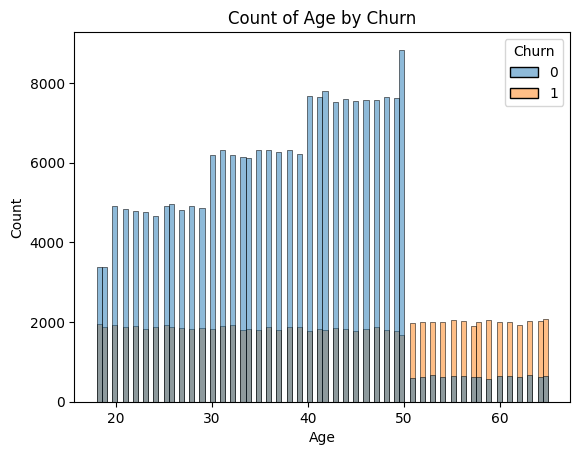

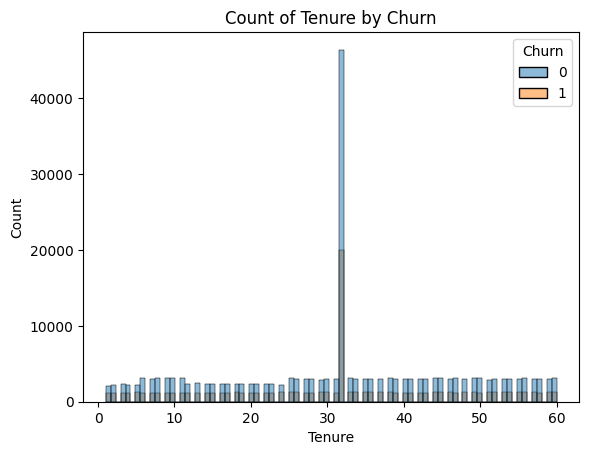

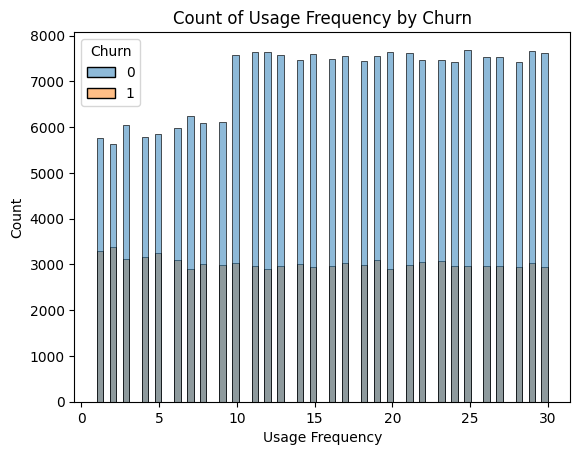

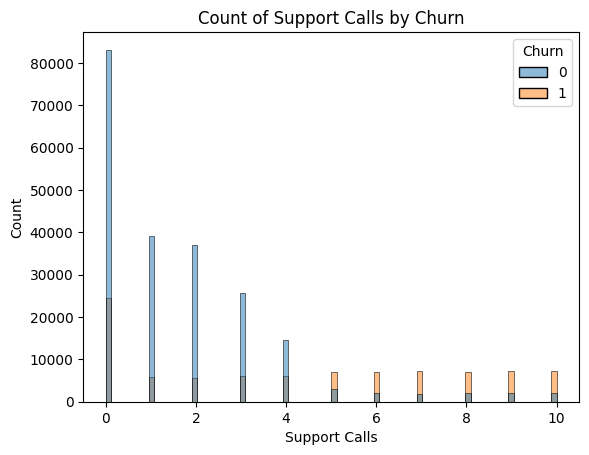

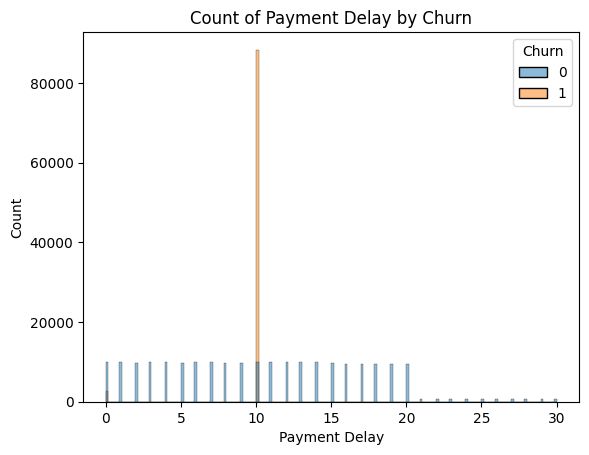

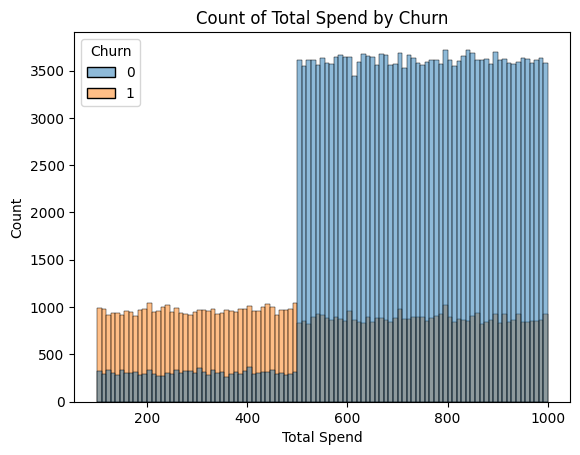

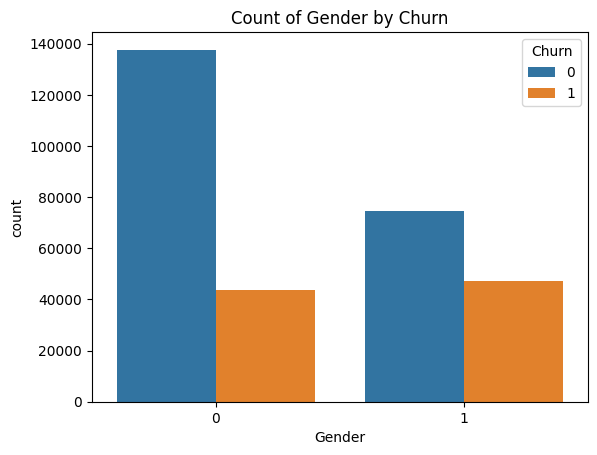

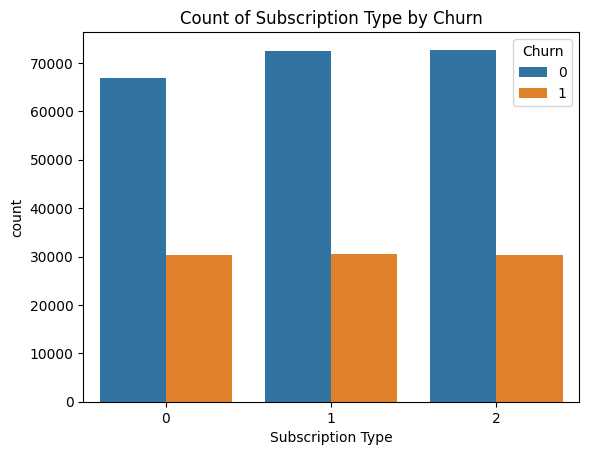

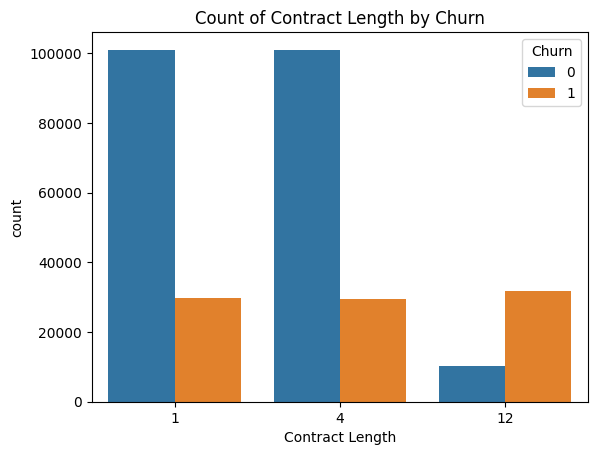

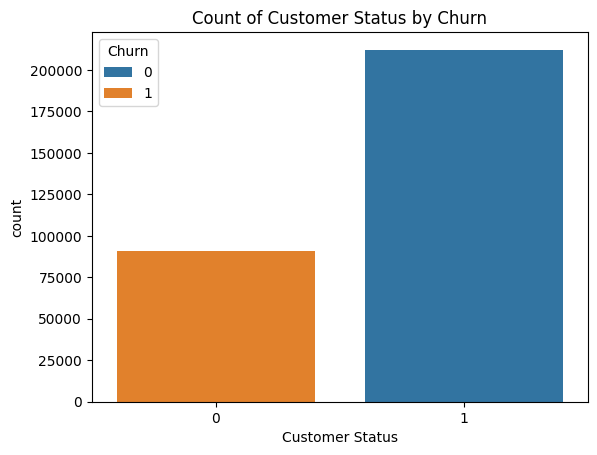

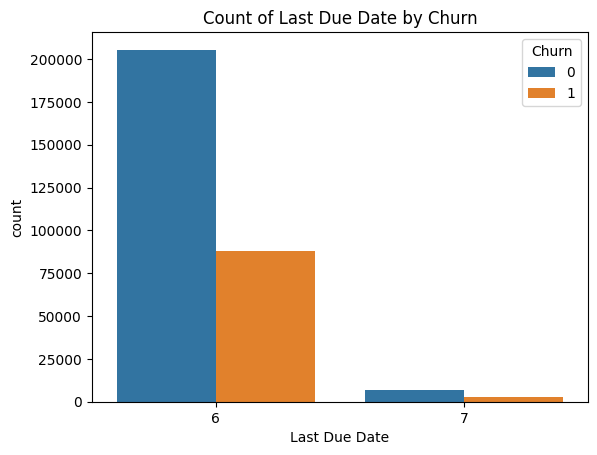

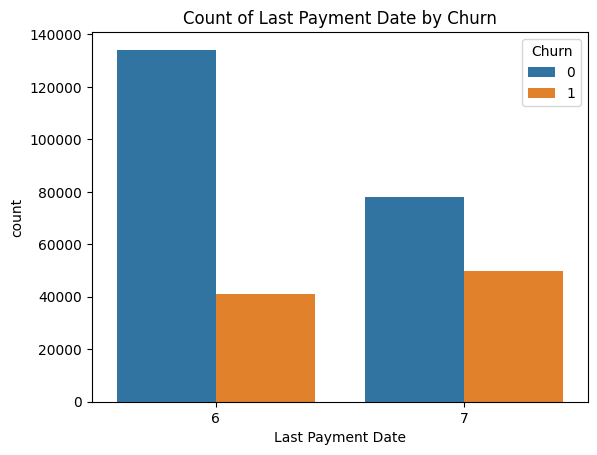

In [490]:
print(customer_churn_raw['Churn'].value_counts())

number_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend']
category_cols = ['Gender', 'Subscription Type', 'Contract Length', 'Customer Status', 'Last Due Date', 'Last Payment Date']

for col in number_cols:
    sns.histplot(data=customer_churn_cleaned, x=col, hue='Churn')
    plt.title(f'Count of {col} by Churn')
    plt.show()
for col in category_cols:
    sns.countplot(data=customer_churn_cleaned, x=col, hue='Churn')
    plt.title(f'Count of {col} by Churn')
    plt.show()


## My Own Classifier

In [491]:
def my_classifier(row):
    if (row['Payment Delay'] == 10 or row['Total Spend'] < 500 or row['Contract Length'] == 12):
        return 1
    else:
        return 0
    
y_pred_my_classifier = customer_churn_cleaned.apply(my_classifier, axis=1).tolist()
y_true = customer_churn_cleaned['Churn'].tolist()

#### Making Probabilities For My Classifier

In [492]:
def my_classifier_proba(row):
    x = 0.1
    if (row['Payment Delay'] == 10):
        x+=0.75
    if (row['Total Spend'] < 500):
         x+=0.6
    if (row['Contract Length'] == 12):
        x+=0.6
    if (row['Customer Status'] == 0):
         x+=0.85
    if (row['Age'] > 50):
         x+=0.6
    if (row['Support Calls'] > 5):
        x+=0.6
    if (row['Last Payment Date'] == 7):
        x+=0.3
    if (row['Gender'] == 1):
        x+=0.2
    return min(x, 0.99)

yproba_my_classifier = customer_churn_cleaned.apply(my_classifier_proba, axis=1).tolist()
y_true = customer_churn_cleaned['Churn'].tolist()


## KNN Model

In [493]:
# Setting X and y for training set
X = customer_churn_cleaned.drop('Churn', axis=1)
y = customer_churn_cleaned['Churn']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

#### Finding Best K-Value

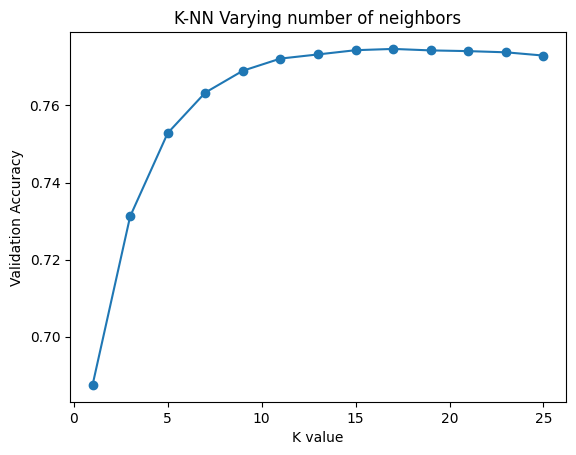

In [494]:
##finding best k-value
test_k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
test_scores = []

for k in test_k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_val, y_val)
    test_scores.append(score)

plt.plot(test_k_values, test_scores, marker='o')
plt.xlabel('K value')
plt.ylabel('Validation Accuracy')
plt.title('K-NN Varying number of neighbors')
plt.show()

#### Will use K=10

In [495]:
X_train
y_train
knn_optimal = KNeighborsClassifier(n_neighbors=10)
knn_optimal.fit(X_train, y_train)


,n_neighbors,10
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## Decision Tree Classifier

In [496]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20, min_samples_leaf=8, random_state=123)
decision_tree.fit(X_train, y_train)


,criterion,'entropy'
,splitter,'best'
,max_depth,10
,min_samples_split,20
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,123
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Validation and Performance

#### My Own Classifier

My Classifier Confusion Matrix:
TP: 27024, FP: 8450, TN: 55207, FN: 257
My Classifier Stats:
0.9042534474037256 0.761797372723685 0.9905795242109894 0.8672573322651083 0.8612540833399729


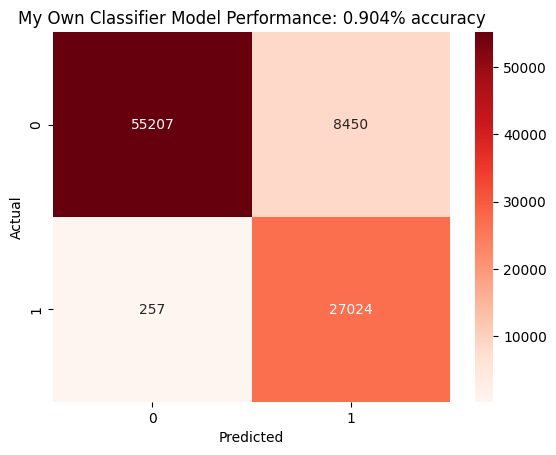

In [497]:
y_pred_my_classifier = X_val.apply(my_classifier, axis=1).tolist()
y_true = y_val.tolist()

TP = 0
TN = 0
FP = 0
FN = 0

cm_my_classifier = confusion_matrix(y_true, y_pred_my_classifier)
TP = cm_my_classifier[1, 1]
TN = cm_my_classifier[0, 0]
FP = cm_my_classifier[0, 1]
FN = cm_my_classifier[1, 0]
print("My Classifier Confusion Matrix:")
print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")

accuracy_my_classifier = accuracy_score(y_true, y_pred_my_classifier)
precision_my_classifier = precision_score(y_true, y_pred_my_classifier)
recall_my_classifier = recall_score(y_true, y_pred_my_classifier)
specificity_my_classifier = TN/(TN + FP)
f1_my_classifier = f1_score(y_true, y_pred_my_classifier)
print("My Classifier Stats:")
print(accuracy_my_classifier, precision_my_classifier, recall_my_classifier, specificity_my_classifier, f1_my_classifier)
sns.heatmap(cm_my_classifier, annot=True, fmt='d', cmap='Reds', cbar=True)
plt.title(f'My Own Classifier Model Performance: {round(accuracy_my_classifier, 3)}% accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Making My Own Classifier Probabilities

##### My Own Classifier ROC Curve

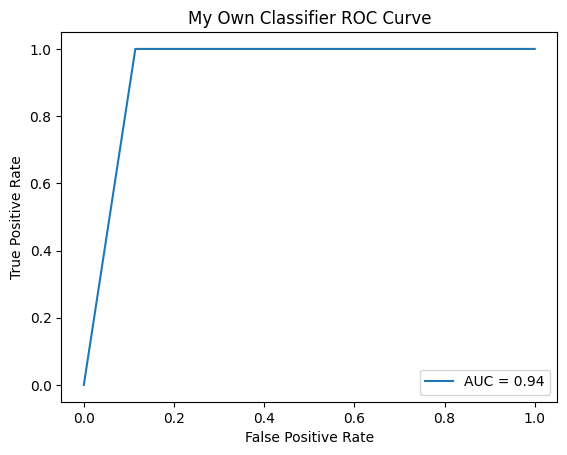

In [498]:
yproba_my_classifier = X_val.apply(my_classifier_proba, axis=1).tolist()
y_true = y_val.tolist()
roc_results_my_classifier = roc_curve(y_val, yproba_my_classifier)
fpr_my_classifier = roc_results_my_classifier[0]
tpr_my_classifier = roc_results_my_classifier[1]
auc_score_my_classifier = roc_auc_score(y_val, yproba_my_classifier)

plt.plot(fpr_my_classifier, tpr_my_classifier, label=f'AUC = {auc_score_my_classifier:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('My Own Classifier ROC Curve')
plt.legend()   
plt.show()

#### KNN

##### Confusion Matrix and Stats

KNN Classifier Confusion Matrix:
TP: 9946, FP: 3539, TN: 60118, FN: 17335
KNN Classifier Stats:
0.7704589940398953 0.7375602521319985 0.36457607858949453 0.48795564931560614 0.9444051714658247


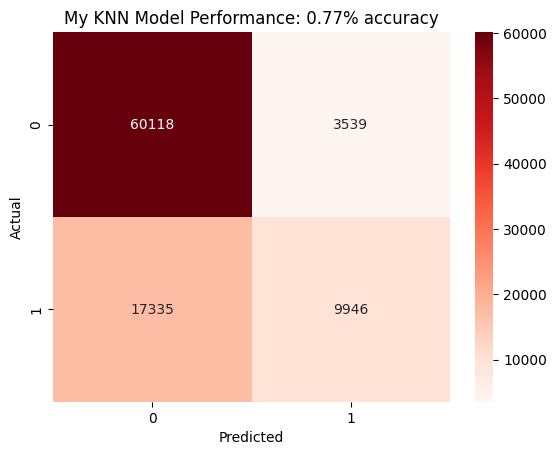

In [499]:
y_pred_knn = knn_optimal.predict(X_val)
cm_knn = confusion_matrix(y_val, y_pred_knn)
tn = cm_knn[0, 0]
fp = cm_knn[0, 1]
fn = cm_knn[1, 0]
tp = cm_knn[1, 1]

print("KNN Classifier Confusion Matrix:")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

accuracy_knn = accuracy_score(y_val, y_pred_knn)
precision_knn = precision_score(y_val, y_pred_knn)
recall_knn = recall_score(y_val, y_pred_knn)
f1_knn = f1_score(y_val, y_pred_knn)
specificity_knn = tn / (tn + fp)
print("KNN Classifier Stats:")
print(accuracy_knn, precision_knn, recall_knn, f1_knn, specificity_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Reds', cbar=True)
plt.title(f'My KNN Model Performance: {round(accuracy_knn, 3)}% accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


##### KNN ROC Curve

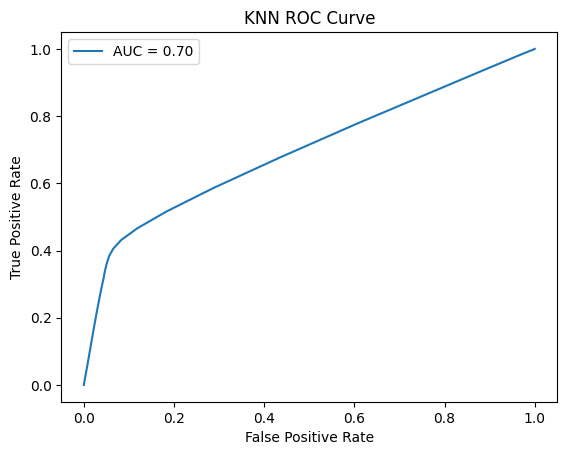

In [500]:
y_proba_knn = knn.predict_proba(X_val)[:, 1]
roc_results_knn = roc_curve(y_val, y_proba_knn)
fpr_knn = roc_results_knn[0]
tpr_knn = roc_results_knn[1]
auc_score_knn = roc_auc_score(y_val, y_proba_knn)

plt.plot(fpr_knn, tpr_knn, label=f'AUC = {auc_score_knn:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend()   
plt.show()

#### Decision Tree

##### Confusion Matrix and Stats

Decision Tree Classifier Confusion Matrix:
TP: 27281, FP: 0, TN: 63657, FN: 0
Decision Tree Classifier Stats:
1.0 1.0 1.0 1.0 1.0


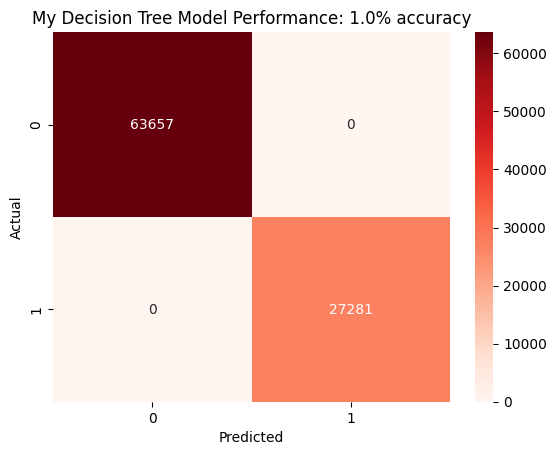

In [501]:
y_pred_decision_tree = decision_tree.predict(X_val)
cm_decision_tree = confusion_matrix(y_val, y_pred_decision_tree)
tn = cm_decision_tree[0, 0]
fp = cm_decision_tree[0, 1]
fn = cm_decision_tree[1, 0]
tp = cm_decision_tree[1, 1]

print("Decision Tree Classifier Confusion Matrix:")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

accuracy_decision_tree = accuracy_score(y_val, y_pred_decision_tree)
precision_decision_tree = precision_score(y_val, y_pred_decision_tree)
recall_decision_tree = recall_score(y_val, y_pred_decision_tree)
f1_decision_tree = f1_score(y_val, y_pred_decision_tree)
specificity_decision_tree = tn / (tn + fp)
print("Decision Tree Classifier Stats:")
print(accuracy_decision_tree, precision_decision_tree, recall_decision_tree, f1_decision_tree, specificity_decision_tree)
sns.heatmap(cm_decision_tree, annot=True, fmt='d', cmap='Reds', cbar=True)
plt.title(f'My Decision Tree Model Performance: {round(accuracy_decision_tree, 3)}% accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Decision Tree ROC Curve

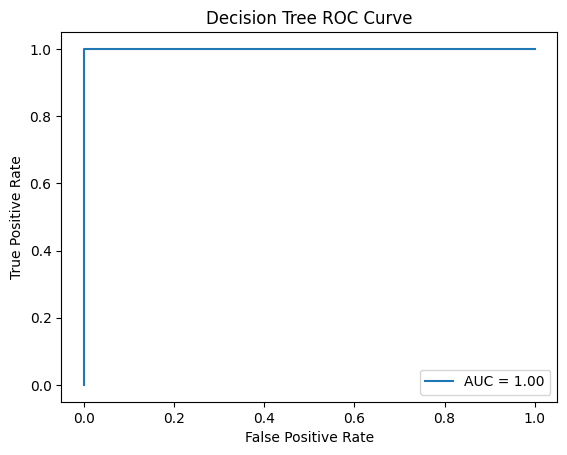

In [502]:
y_proba_decision_tree = decision_tree.predict_proba(X_val)[:, 1]
roc_results_decision_tree = roc_curve(y_val, y_proba_decision_tree)
fpr_decision_tree = roc_results_decision_tree[0]
tpr_decision_tree = roc_results_decision_tree[1]
auc_score_decision_tree = roc_auc_score(y_val, y_proba_decision_tree)

plt.plot(fpr_decision_tree, tpr_decision_tree, label=f'AUC = {auc_score_decision_tree:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend()   
plt.show()


## Cleaning Test Dataset

In [503]:
test_df = pd.read_csv('/Users/joshbolton/ml_final_project/data/raw/test.csv') 
customer_ids = test_df['CustomerID']

# Copy test dataframe
test_df_processed = test_df.copy()


# Fill numeric missing values using training medians
test_df_processed['Tenure'] = test_df_processed['Tenure'].fillna(customer_churn_cleaned['Tenure'].median())
test_df_processed['Payment Delay'] = test_df_processed['Payment Delay'].fillna(customer_churn_cleaned['Payment Delay'].median())
test_df_processed['Last Interaction'] = test_df_processed['Last Interaction'].fillna(customer_churn_cleaned['Last Interaction'].median())

# Support Calls: replace 'None'/'none' with 0 and convert to numeric
test_df_processed['Support Calls'] = test_df_processed['Support Calls'].replace({'None': 0, 'none': 0})
test_df_processed['Support Calls'] = pd.to_numeric(test_df_processed['Support Calls'], errors='coerce').fillna(0).astype(int)

# Encode categorical features exactly as training set
test_df_processed['Gender'] = test_df_processed['Gender'].replace({'Male': 0, 'Female': 1})
test_df_processed['Customer Status'] = test_df_processed['Customer Status'].replace({'inactive': 0, 'active': 1})
test_df_processed['Subscription Type'] = test_df_processed['Subscription Type'].replace({'Basic': 0, 'Standard': 1, 'Premium': 2})
test_df_processed['Contract Length'] = test_df_processed['Contract Length'].replace({'Annual': 1, 'Quarterly': 4, 'Monthly': 12})

# Convert date columns to month
test_df_processed['Last Due Date'] = test_df_processed['Last Due Date'].astype(str).str[:2].astype(int)
test_df_processed['Last Payment Date'] = test_df_processed['Last Payment Date'].astype(str).str[:2].astype(int)


/var/folders/0b/ymdbnxhd1c51_7jjn1h8g7tw0000gn/T/ipykernel_24319/2379424756.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df_processed['Gender'] = test_df_processed['Gender'].replace({'Male': 0, 'Female': 1})
/var/folders/0b/ymdbnxhd1c51_7jjn1h8g7tw0000gn/T/ipykernel_24319/2379424756.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df_processed['Customer Status'] = test_df_processed['Customer Status'].replace({'inactive': 0, 'active': 1})
/var/folders/0b/ymdbnxhd1c51_7jjn1h8g7tw0000gn/T/ipykernel_24319/2379424

### My Classifier Submission

In [504]:
X_test = test_df_processed
X_test = X_test[X_train.columns]
X_test

probabilities_my_classifier = X_test.apply(my_classifier_proba, axis=1).tolist()

my_classifier_submission = pd.DataFrame({
    'CustomerID': customer_ids,
    'Churn': probabilities_my_classifier
})

my_classifier_submission.to_csv('/Users/joshbolton/ml_final_project/src/models/my_classifier_submission.csv', index=False)

### KNN Submission

In [505]:
X_test = test_df_processed
X_test = X_test[X_train.columns]
X_test

probabilities_knn = knn_optimal.predict_proba(X_test)[:, 1]

my_knn_submission = pd.DataFrame({
    'CustomerID': customer_ids,
    'Churn': probabilities_knn
})

my_knn_submission.to_csv('/Users/joshbolton/ml_final_project/src/models/my_knn_submission.csv', index=False)

### Decision Tree Submission

In [506]:
X_test = test_df_processed
X_test = X_test[X_train.columns]
X_test

probabilities_decision_tree = decision_tree.predict_proba(X_test)[:, 1]

my_decision_tree_submission = pd.DataFrame({
    'CustomerID': customer_ids,
    'Churn': probabilities_decision_tree
})

my_decision_tree_submission.to_csv('/Users/joshbolton/ml_final_project/src/models/my_decision_tree_submission.csv', index=False)

In [507]:
print(X_train.columns)
print(customer_churn_cleaned.head())


Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Customer Status',
       'Last Due Date', 'Last Payment Date'],
      dtype='object')
   CustomerID  Age  Gender  Tenure  Usage Frequency  Support Calls  \
0      160831   34       0    32.0               26              0   
1      354435   30       0    36.0               22              0   
2      444576   23       0    44.0               14              0   
3      130847   24       0    39.0               21              2   
4      108121   26       0    32.0               26              1   

   Payment Delay  Subscription Type  Contract Length  Total Spend  \
0           17.0                  0                4       890.21   
1           15.0                  0                1       954.37   
2           10.0                  2                1       674.00   
3           14.0          